# Bayesian Online Changepoint Detection
* It is a probabilistic model to identify the level shifts(mean-shifts) or variational shifts in incoming dataset
* It predicts posterior probability of run length(interval between to changepoints in dataset) so for a dataset of n-samples, there are n-possible run lengths.
* The model calculates probability that all those possible run lengths for each datapoint to be changepoints so it creates $NxN$ matrix where $N$ is length of the dataset
* So we set default threshold probability for it be a changepoint is $0.5$.

## Required Arguments to run the program:
* Arguments are divided into two parts one for reader and the other one is parameters for algorithm
* reader_kwargs={
            'assetno':list of assetno's in quotes,
            'from_timestamp':from_timestamp must be in epoch format (ms),
            'to_timestamp':to_timestamp must be in epoch format (ms),
            'con':connection url to opentsdb or csv filepath in quotes,
            'para_list': list of metric names in quotes,
            'source_type':takes opentsdb or csv in quotes,
            'table_name':table_name in quotes,
            'qry_str':qry_str in quotes,
            'impute_fill_method':default fill forward,
            'down_sampling_method':default None,
            'down_sampling_window':default None,
            'freq':default None,
            'resample_fill_method':default None,
            'to_resample':default False,
            'to_impute':default True
        }

* algo_kwargs={
            'is_train':Takes Boolean argument true or false, true for model which requires training,
            'data_col_index':1,
            'pthres':thres_prob,
            'Nw':samples_to_wait,
            'mean_runlen':expected_run_length
        }

In [1]:
import writefile_run as writefile_run

In [2]:
%%writefile_run bayeschangept_sprint1.py

'''
importing all the required header files
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import datetime as dt

import time
import os
# Importing reader and checker python files as modules
import reader_writer.db_properties as db_props
import reader_writer.writer_configs as write_args
import psycopg2

from utils.preprocessors import *
from utils.data_handler import *
from utils.bayesian_changept_detector import *
# from utils.error_codes import error_codes
import utils.error_codes as error_codes
import type_checker as type_checker
import json
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = 12, 9
rcParams[ 'axes.grid']=True

Use scipy logsumexp().


In [3]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
%%writefile_run bayeschangept_sprint1.py -a


algo_params_type ={
            'is_train':bool,
            'data_col_index':int,
            'pthres':float,
            'Nw':int,
            'mean_runlen':int
        }

In [5]:
%%writefile_run bayeschangept_sprint1.py -a


def call(assetno,from_timestamp,to_timestamp,con,para_list,source_type='opentsdb',table_name='',
        qry_str='',impute_fill_method='forward',down_sampling_method=None,down_sampling_window=None,freq=None,
        resample_fill_method=None,to_resample=None,to_impute=None,thres_prob=0.5,samples_to_wait=10,expected_run_length=100):

        reader_kwargs={
            'assetno':assetno,
            'from_timestamp':from_timestamp,
            'to_timestamp':to_timestamp,
            'con':con,
            'para_list':para_list,
            'source_type':source_type,
            'table_name':table_name,
            'qry_str':qry_str,
            'impute_fill_method':impute_fill_method,
            'down_sampling_method':down_sampling_method,
            'down_sampling_window':down_sampling_window,
            'freq':freq,
            'resample_fill_method':resample_fill_method,
            'to_resample':to_resample,
            'to_impute':to_impute
        }

        algo_kwargs={
            'is_train':False,
            'data_col_index':1,
            'pthres':thres_prob,
            'Nw':samples_to_wait,
            'mean_runlen':expected_run_length
        }
                    
        try: 
            error_codes.reset()
            checker = type_checker.Type_checker(kwargs=algo_kwargs,ideal_args_type=algo_params_type)
            res = checker.params_checker()
            if(res!=None):
                return res
            
            data_reader = Data_reader(reader_kwargs=reader_kwargs)
                
            entire_data = data_reader.read()

            writer_data = []
            anomaly_detectors = []
            if(len(entire_data)!=0 and entire_data!=None):
                for i,data_per_asset in enumerate(entire_data):
                    assetno = reader_kwargs['assetno'][i]
                    data_per_asset[data_per_asset.columns[1:]] = normalise_standardise(data_per_asset[data_per_asset.columns[1:]])
                    
                    for data_col in range(1,len(data_per_asset.columns[1:])+1):
                        algo_kwargs['data_col_index'] = data_col
                        print("\nAnomaly detection for AssetNo : {} , Metric : {}\n ".format(assetno,data_per_asset.columns[data_col]))
                        anomaly_detector = Bayesian_Changept_Detector(data_per_asset,assetno=assetno,**algo_kwargs)
                        data,anom_indexes = anomaly_detector.detect_anomalies()

                        sql_query_args = write_args.writer_kwargs
                        table_name = write_args.table_name
                        window_size = 10

                        anomaly_detectors.append(anomaly_detector)
                    

                writer = Postgres_Writer(anomaly_detectors,db_credentials=db_props.db_connection,sql_query_args=sql_query_args,
                                        table_name=table_name,window_size=window_size)

                res = writer.map_outputs_and_write()
                return res
            else:
                return error_codes.error_codes['data_missing']
        except Exception as e:
#             error_message['message'] = e
            error_codes.error_codes['unknown']['message']=e
            return error_codes.error_codes['unknown']

In [6]:
# %%writefile_run bayeschangept_sprint1.py -a


assetno = ['1']
con = '52.173.76.89:4242'
src_type =  'opentsdb'
param = ['FE-001.DRIVEENERGY']
from_timestamp = 1520402214
to_timestamp = 1520407294

Data reader initialised 

http://52.173.76.89:4242/api/query?start=1520402214&end=1520407294&ms=true&m=max:none:FE-001.DRIVEENERGY{AssetNo=1}
Getting the dataset from the reader....

Asset no : 1 
               assetno FE-001.DRIVEENERGY
timestamp                               
1520402214990       1            177.208
1520402224990       1            443.688
1520402234990       1            127.826
1520402244990       1            167.014
1520402254990       1            418.113 


Anomaly detection for AssetNo : 1 , Metric : FE-001.DRIVEENERGY
 
Shape of the dataset : 
(508, 2)
Overview of first five rows of dataset : 


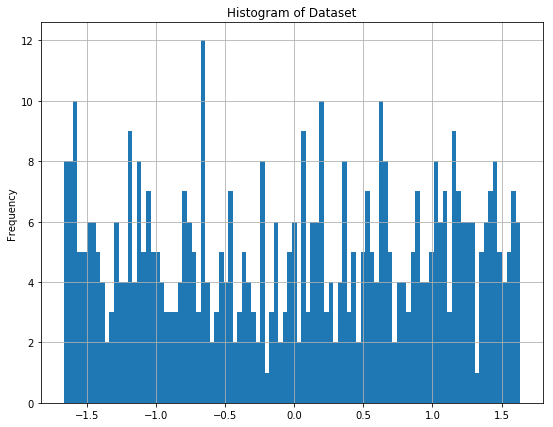

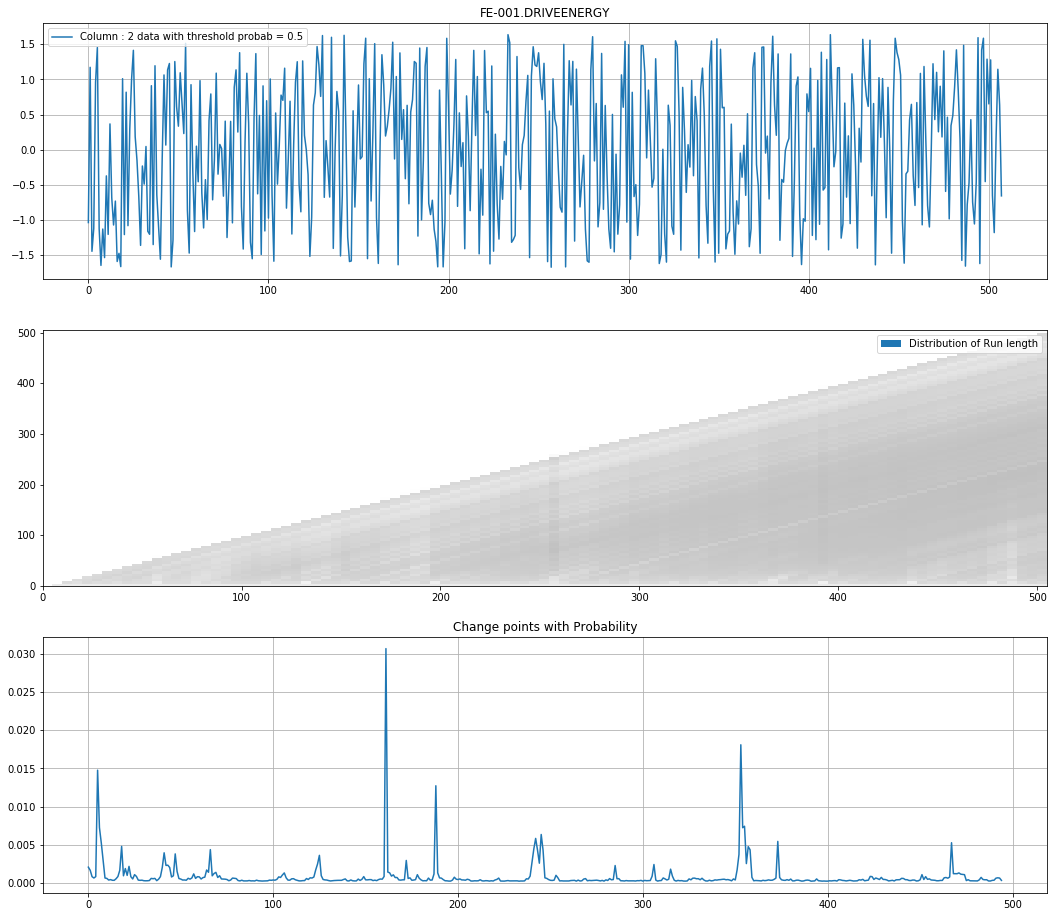


 No of Anomalies detected = 0
Postgres writer initialised 


No anomaly detected to write

{'code': '200', 'status': 'OK'}


In [7]:
# %%writefile_run bayeschangept_sprint1.py -a


kwargs = {
            'assetno':assetno,
            'from_timestamp':from_timestamp,
            'to_timestamp':to_timestamp,
            'con':con,
            'para_list':param,
            'source_type':src_type,
            'table_name':'',
            'qry_str':'',
            'impute_fill_method':'forward',
            'down_sampling_method':None,
            'down_sampling_window':None,
            'freq':None,
            'resample_fill_method':None,
            'to_resample':None,
            'to_impute':True,
            'thres_prob':0.5,
            'samples_to_wait':10,
            'expected_run_length':100
        }

   
res = call(**kwargs)
print(res)

In [8]:
def preparecsvtoread(filepath,filename,target_dir,assetno='1'):
    df  = pd.read_csv(filepath)
    df['assetno'] = assetno
    df = df.rename(columns={df.columns[0]:'timestamp'})
    df['timestamp'] = (pd.to_datetime(df['timestamp'],infer_datetime_format=True).astype(np.int64)/(1e6)).astype(np.int64)
    metric_names = df.columns[1:-1]
    target_filepath = os.path.join(target_dir,filename)
    df.to_csv(target_filepath,index=False)
    return target_filepath,list(metric_names)


Detecting anomalies for alcohol-demand-log-spirits-consu.csv

params: ['Alcohol demand (log spirits consumption per head), UK, 1870-1938']

Data reader initialised 

Getting the dataset from the reader....

Asset no : 1 
                assetno  \
timestamp                
-3.147898e+12      1.0   
-3.137357e+12      1.0   
-3.126816e+12      1.0   
-3.116362e+12      1.0   
-3.105821e+12      1.0   

               Alcohol demand (log spirits consumption per head), UK, 1870-1938  
timestamp                                                                        
-3.147898e+12                                              1.957                 
-3.137357e+12                                              1.979                 
-3.126816e+12                                              2.012                 
-3.116362e+12                                              2.045                 
-3.105821e+12                                              2.056                  


Anomaly detection

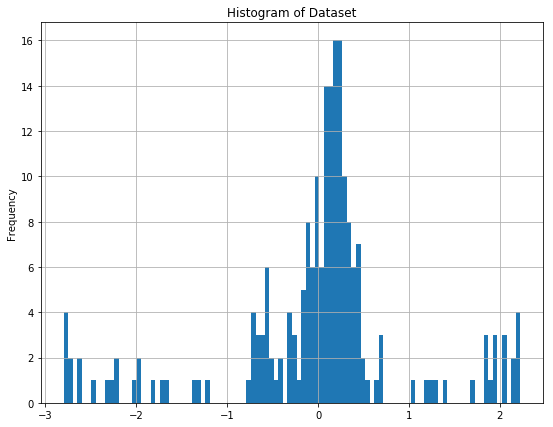

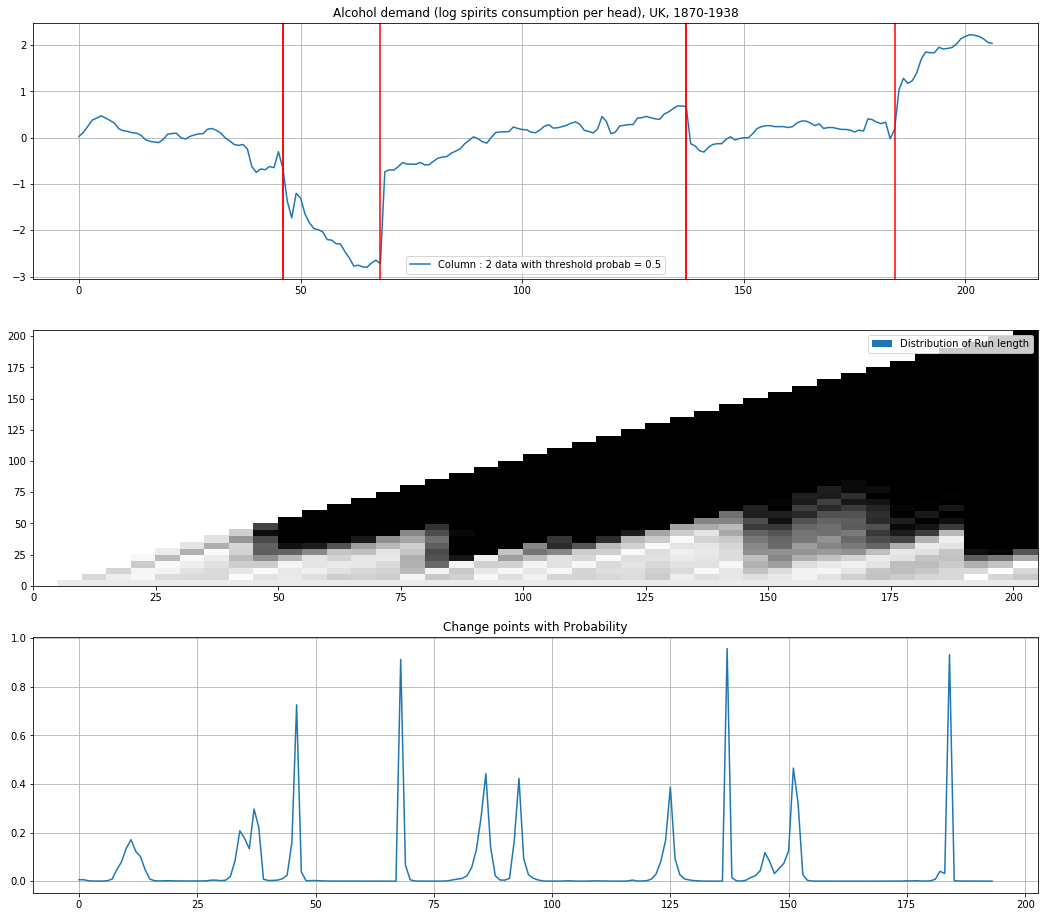


 No of Anomalies detected = 6
Postgres writer initialised 


 Successfully written into database

{'code': '200', 'status': 'OK'}

Detecting anomalies for average-annual-temperature-centr.csv

params: ['Average annual temperature, central England, 1723 ? 1970']

Data reader initialised 

Getting the dataset from the reader....

Asset no : 1 
            assetno  Average annual temperature, central England, 1723 ? 1970
timestamp                                                                   
0.0            1.0                                               9.77       
0.0            1.0                                               9.27       
0.0            1.0                                               8.66       
0.0            1.0                                               9.34       
0.0            1.0                                               9.94        


Anomaly detection for AssetNo : 1 , Metric : Average annual temperature, central England, 1723 ? 1970
 
Shape of

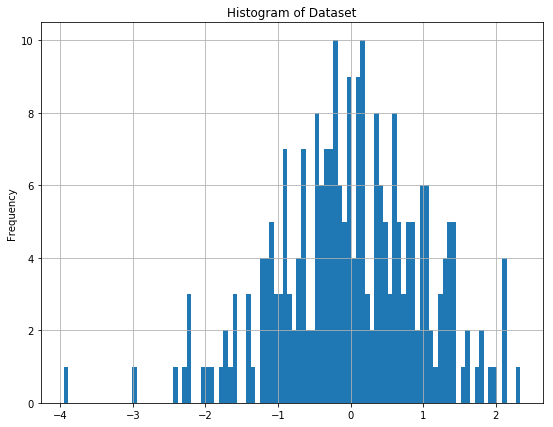

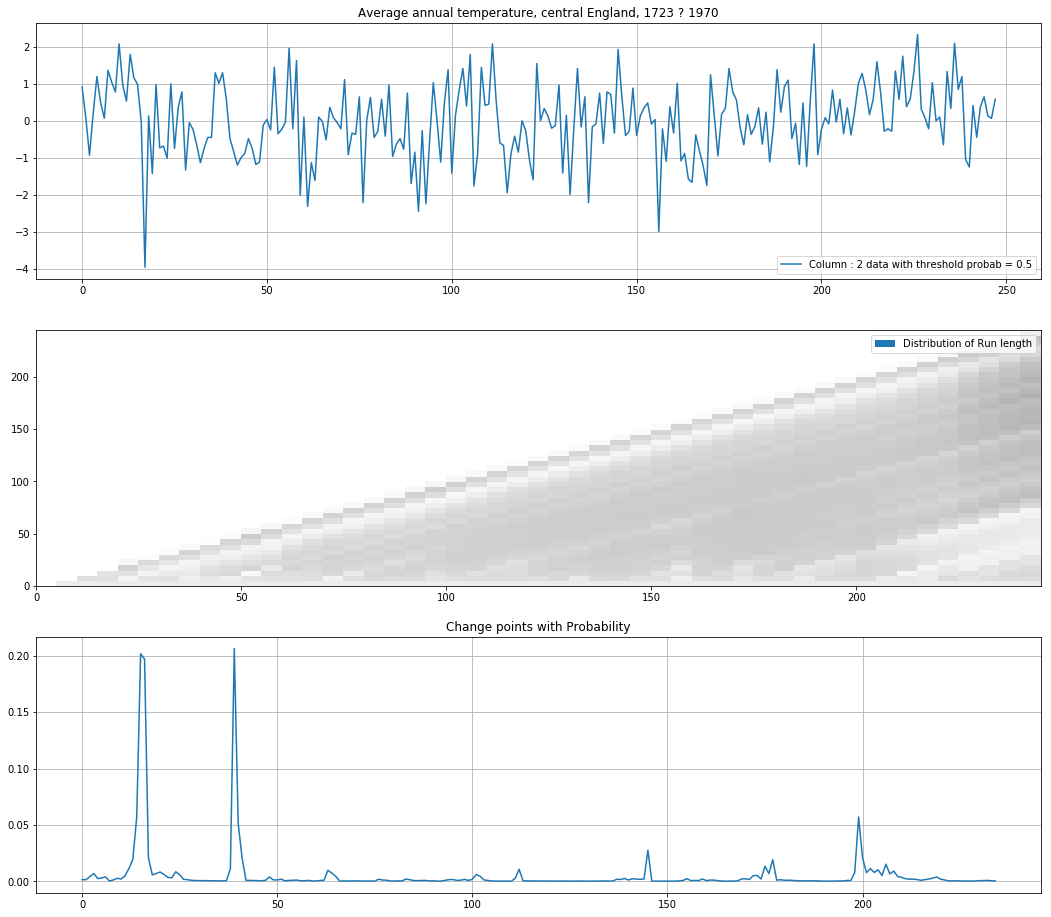


 No of Anomalies detected = 0
Postgres writer initialised 


No anomaly detected to write

{'code': '200', 'status': 'OK'}

Detecting anomalies for mean-monthly-temperature-1907-19.csv

params: ['Mean monthly temperature, 1907 ? 1972']

Data reader initialised 

Getting the dataset from the reader....

Asset no : 1 
                assetno  Mean monthly temperature, 1907 ? 1972
timestamp                                                    
-1.988150e+12      1.0                                   33.3
-1.985472e+12      1.0                                   46.0
-1.983053e+12      1.0                                   43.0
-1.980374e+12      1.0                                   55.0
-1.977782e+12      1.0                                   51.8 


Anomaly detection for AssetNo : 1 , Metric : Mean monthly temperature, 1907 ? 1972
 
Shape of the dataset : 
(792, 2)
Overview of first five rows of dataset : 


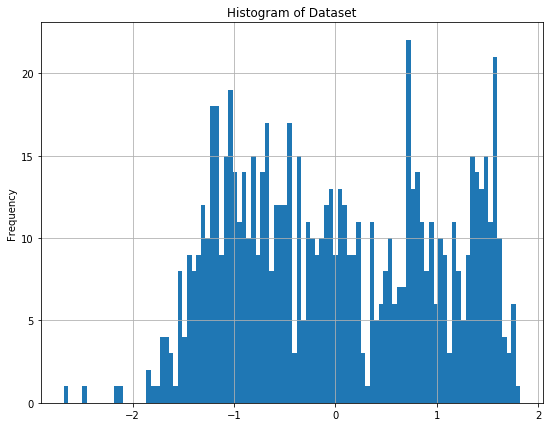

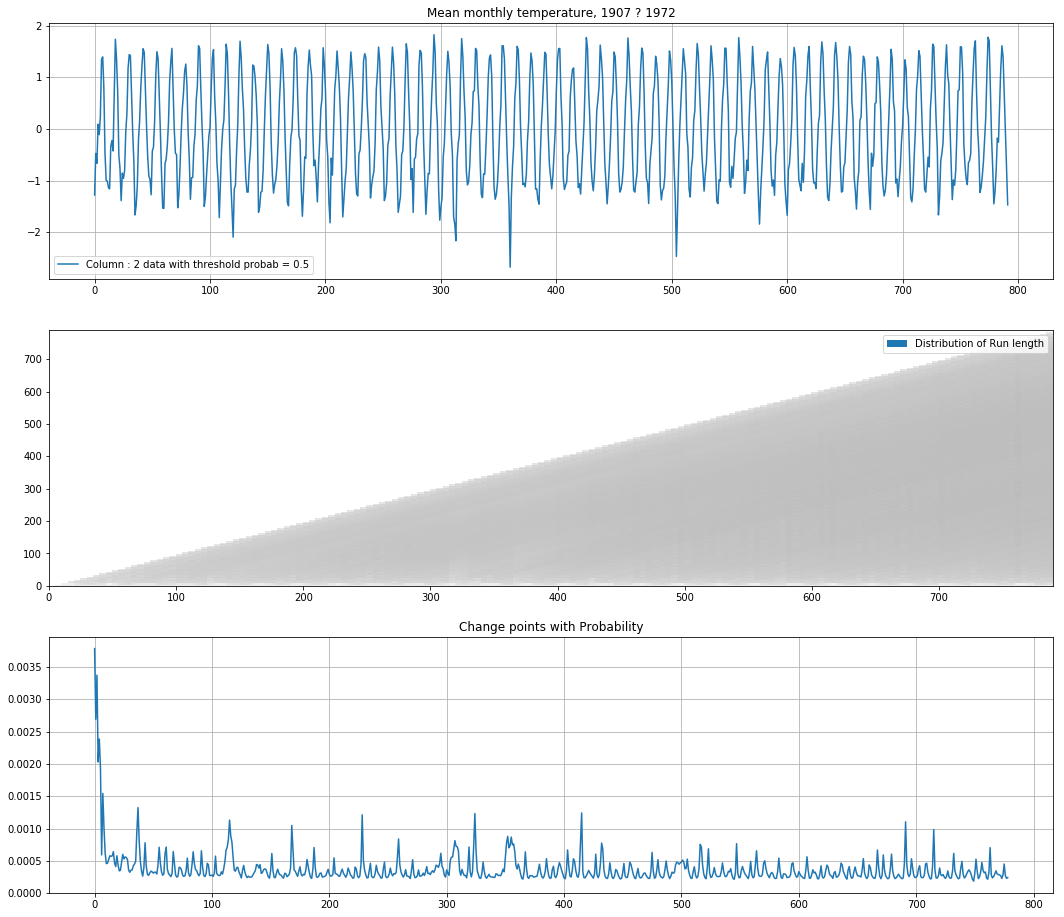


 No of Anomalies detected = 0
Postgres writer initialised 


No anomaly detected to write

{'code': '200', 'status': 'OK'}

Detecting anomalies for methane-input-into-gas-furnace-c.csv

params: ['CO2', 'Methane']

Data reader initialised 

Getting the dataset from the reader....

Asset no : 1 
               assetno   CO2  Methane
timestamp                           
7.808400e+09      1.0  53.8    0.109
7.808940e+09      1.0  53.6    0.000
7.809480e+09      1.0  53.5    0.178
7.810020e+09      1.0  53.5    0.339
7.810560e+09      1.0  53.4    0.373 


Anomaly detection for AssetNo : 1 , Metric : CO2
 
Shape of the dataset : 
(296, 3)
Overview of first five rows of dataset : 


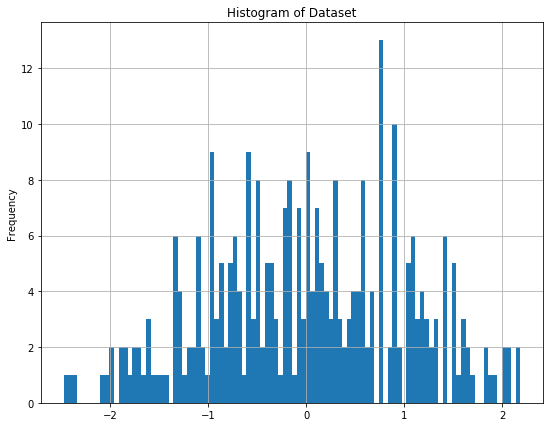

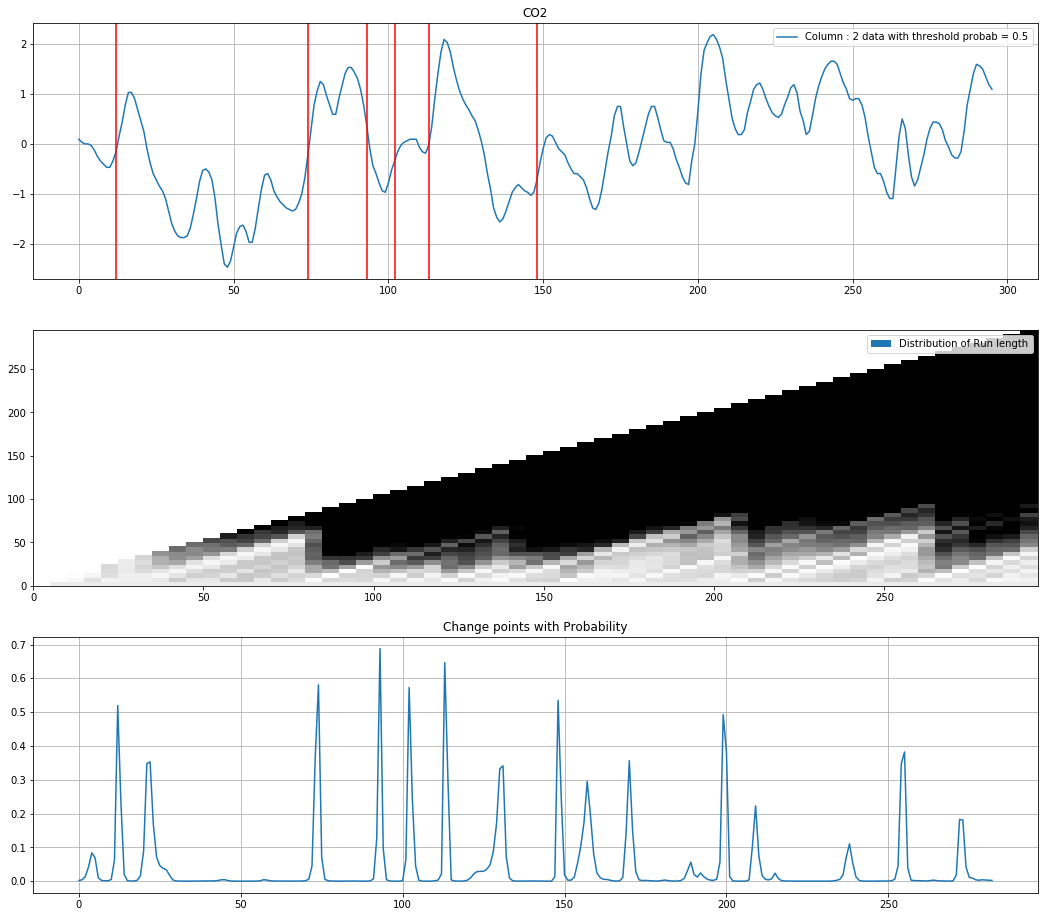


 No of Anomalies detected = 6

Anomaly detection for AssetNo : 1 , Metric : Methane
 
Shape of the dataset : 
(296, 3)
Overview of first five rows of dataset : 


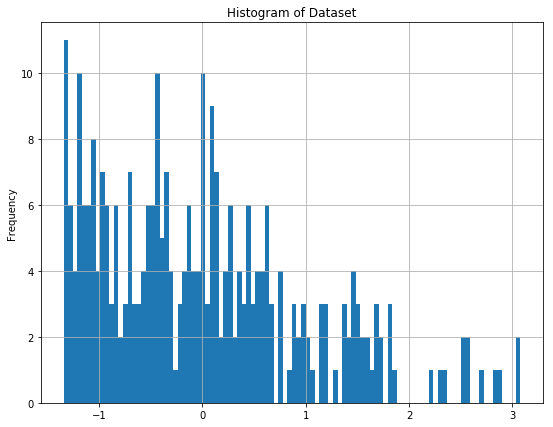

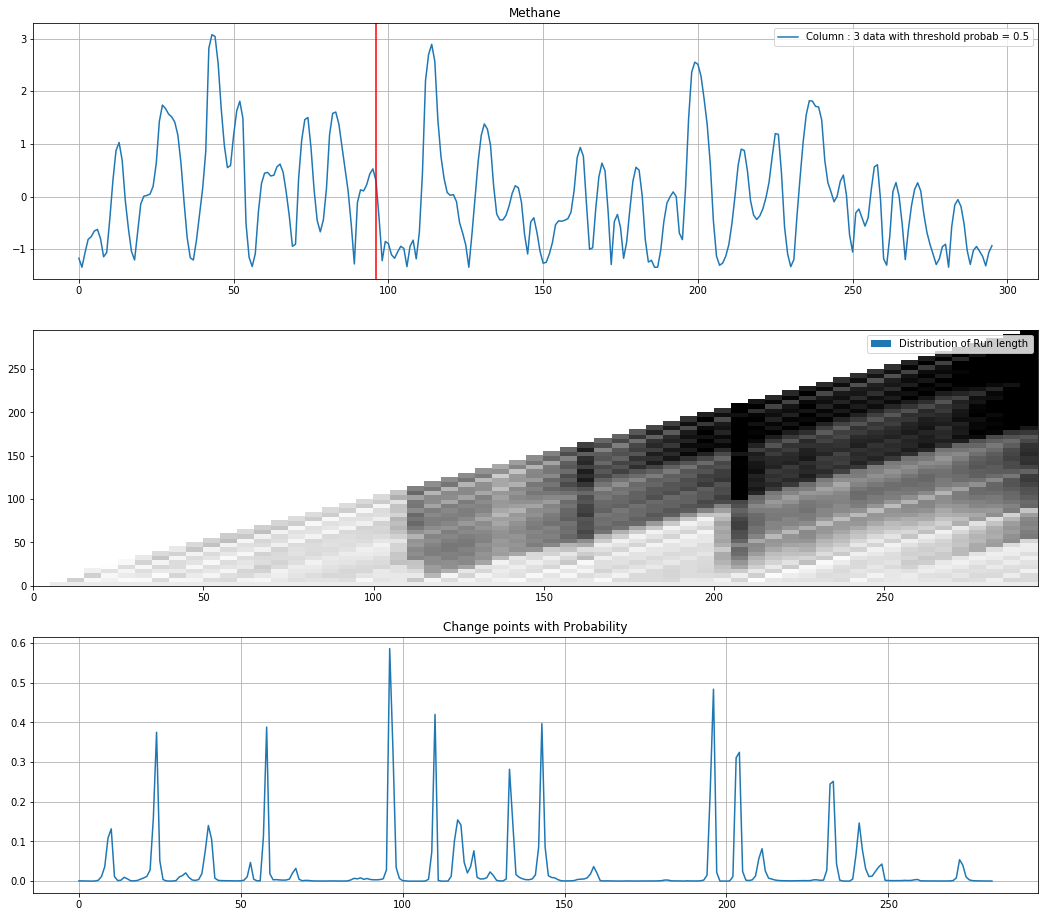


 No of Anomalies detected = 1
Postgres writer initialised 


 Successfully written into database

{'code': '200', 'status': 'OK'}

Detecting anomalies for monthly-us-female-20-years-and-o.csv

params: ['Monthly U.S. female (20 years and over) unemployment figures (10**3) 1948-1981']

Data reader initialised 

Getting the dataset from the reader....

Asset no : 1 
                assetno  \
timestamp                
-6.943104e+11      1.0   
-6.916320e+11      1.0   
-6.891264e+11      1.0   
-6.864480e+11      1.0   
-6.838560e+11      1.0   

               Monthly U.S. female (20 years and over) unemployment figures (10**3) 1948-1981  
timestamp                                                                                      
-6.943104e+11                                              446.0                               
-6.916320e+11                                              650.0                               
-6.891264e+11                                              592.0 

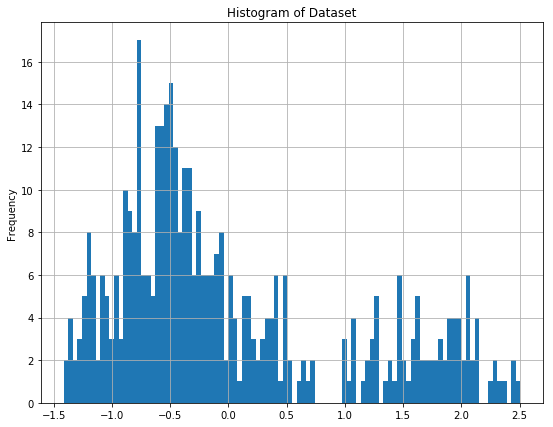

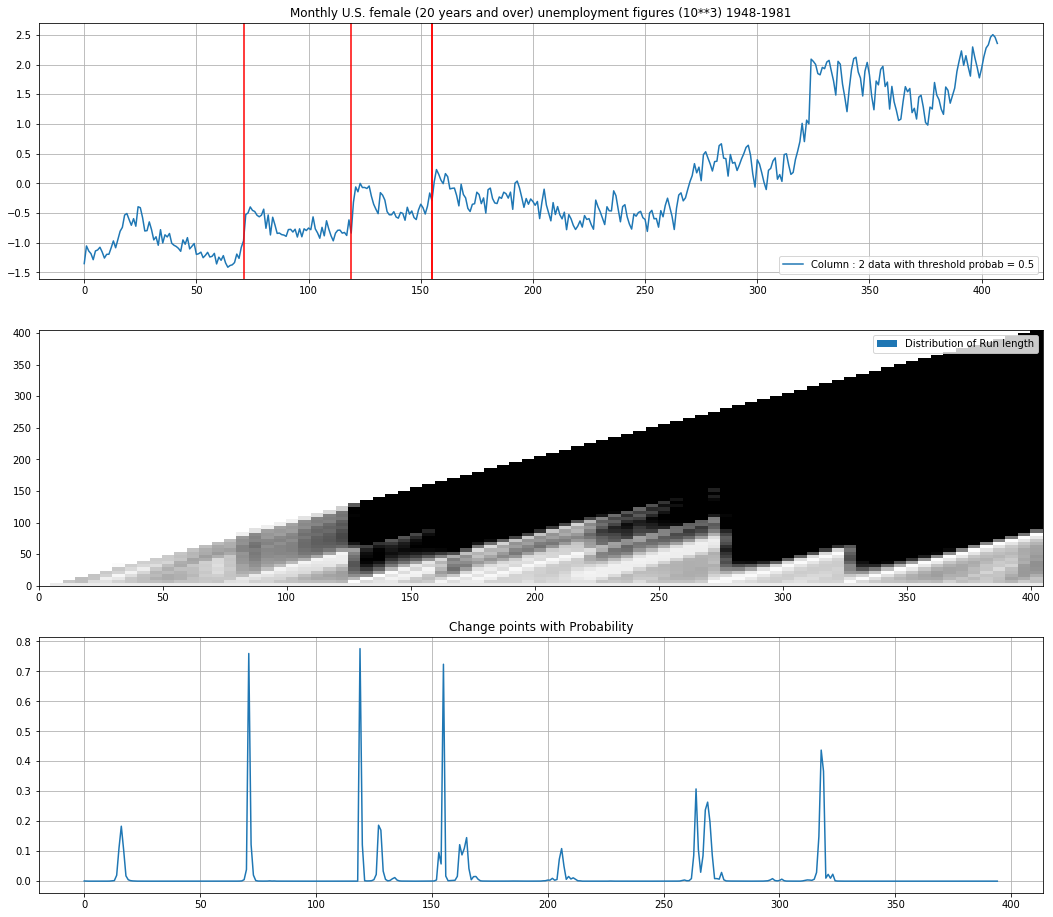


 No of Anomalies detected = 4
Postgres writer initialised 


 Successfully written into database

{'code': '200', 'status': 'OK'}

Detecting anomalies for winter-negative-temperature-sum-.csv

params: ['Winter negative temperature sum (in deg. C), 1781 ? 1988']

Data reader initialised 

Getting the dataset from the reader....

Asset no : 1 
            assetno  Winter negative temperature sum (in deg. C), 1781 ? 1988
timestamp                                                                   
0.0            1.0                                              272.3       
0.0            1.0                                              207.8       
0.0            1.0                                              545.7       
0.0            1.0                                              557.5       
0.0            1.0                                              260.6        


Anomaly detection for AssetNo : 1 , Metric : Winter negative temperature sum (in deg. C), 1781 ? 1988
 
Shape of

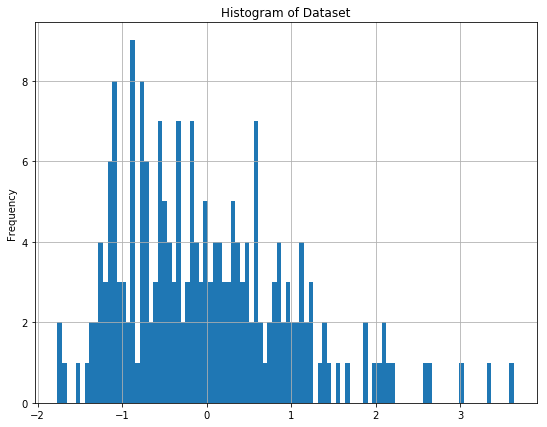

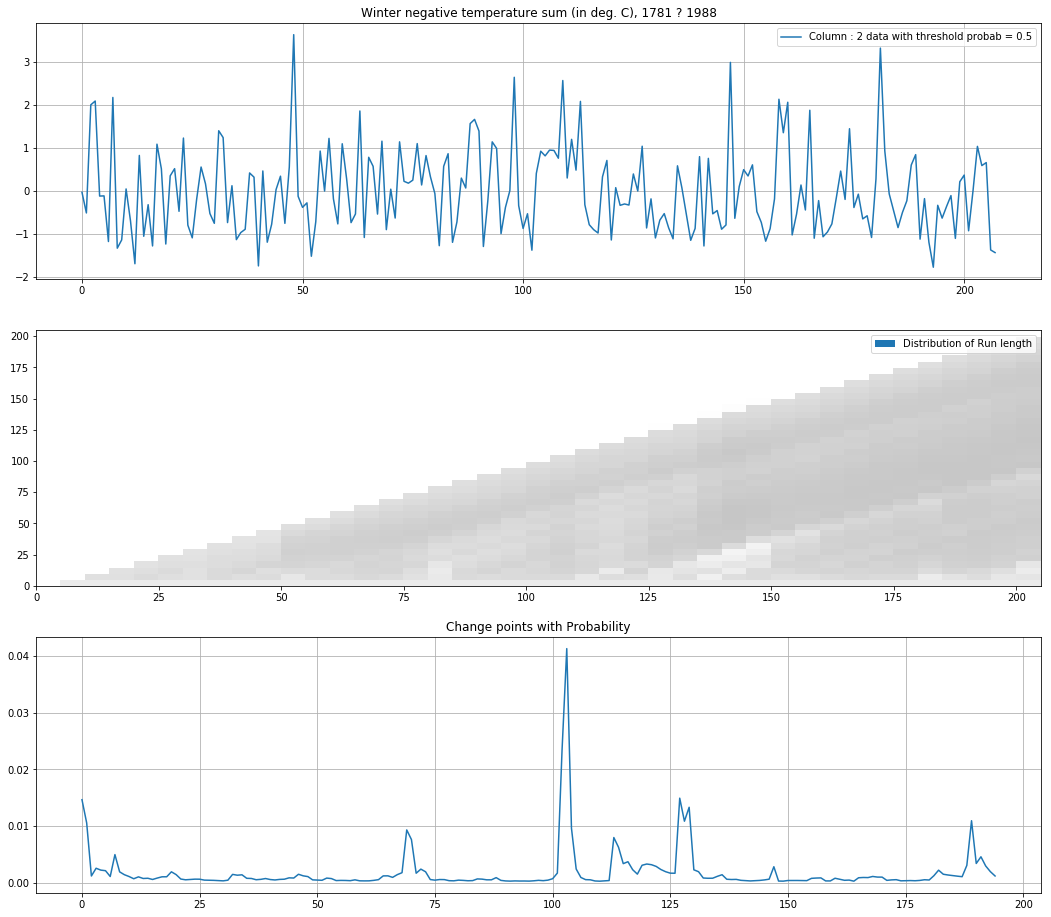


 No of Anomalies detected = 0
Postgres writer initialised 


No anomaly detected to write

{'code': '200', 'status': 'OK'}


In [9]:
data_dir = 'dataset/sample_csv_files/'
target_dir = 'dataset/reader_csv_files/'
assetno = ['1']
for filename in os.listdir(data_dir):
    
    name,ext = os.path.splitext(filename)
    if ext != '.csv':continue
    infile = os.path.join(data_dir,filename)
    print("\nDetecting anomalies for {}\n".format(filename))
    
    con,param = preparecsvtoread(filepath=infile,filename=filename,target_dir=target_dir,assetno=assetno[0])
    print('params: {}\n'.format(param))
    
    kwargs = {
            'assetno':assetno,
            'from_timestamp':-int(2**63),
            'to_timestamp':int(2**63),
            'con':con,
            'para_list':param,
            'source_type':'csv',
            'table_name':'',
            'qry_str':'',
            'impute_fill_method':'forward',
            'down_sampling_method':None,
            'down_sampling_window':None,
            'freq':None,
            'resample_fill_method':None,
            'to_resample':None,
            'to_impute':True,
            'thres_prob':0.5,
            'samples_to_wait':10,
            'expected_run_length':100
        }

   
    res = call(**kwargs)
    print(res)


# Conclusion:
* Hence we observe that **Bayesian Changepoint Detection** works well only on level shifts or variational shift datasets over outlier or surge,sag datasets